In [14]:
# import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import warnings
warnings.filterwarnings("ignore")

import os

path = os.getcwd()
os.chdir(f"{path}")

In [2]:
# import necessary data

paperdata = pd.read_csv("../Data/paperdata.csv")
cb = pd.read_csv("../Data/citationBara.csv")
primdata = pd.read_csv("../Data/primdata.csv")
lastdata = pd.read_csv("../Data/lastdata.csv")

# Network Analyses

In [3]:
### DataFrame: {citing_doi, citing_year, cited_doi}

#### If primary author analysis
citinfo = primdata[["doi", "year"]].drop_duplicates(subset = 'doi')

#### If last author analysis
# citinfo = lastdata[["doi", "year"]].drop_duplicates(subset = 'doi')

cols = ['citing_doi', 'citing_year', 'cited_doi']

citinfo = citinfo.merge(cb, left_on = 'doi', right_on = 'citing_doi',
              how = 'inner').drop(['doi'], axis=1).rename(
                  {'year': 'citing_year'}, axis=1).reindex(
                      columns=cols).sort_values('cited_doi')

citinfo.head()

,citing_doi,citing_year,cited_doi
120191,10.1103/PhysRev.21.250,1923,10.1103/PhysRev.1.124
123113,10.1103/PhysRev.40.281,1932,10.1103/PhysRev.1.124
120140,10.1103/PhysRev.2.109,1913,10.1103/PhysRev.1.124
144119,10.1103/PhysRev.8.738,1916,10.1103/PhysRev.1.124
2739988,10.1103/PhysRevSeriesI.2.1,1894,10.1103/PhysRev.1.2


## Self-citation Analysis

In [4]:
# creating all citation dataset with gender information

self1 = citinfo.copy()
self2 = paperdata[['doi','id','gender']]

selfinfo = self1.merge(self2, left_on='citing_doi', right_on='doi').drop(
    ['doi'], axis=1).drop_duplicates().reset_index(drop=True)
selfinfo.columns = ['citing_doi', 'citing_year', 'cited_doi', 'citing_id', 'citing_gender']

selfinfo = selfinfo.merge(self2, left_on='cited_doi', right_on='doi').drop(
    ['doi', 'gender'], axis=1).drop_duplicates().reset_index(drop=True)
selfinfo.columns = ['citing_doi', 'citing_year', 'cited_doi', 'citing_id', 'citing_gender', 'cited_id']

print(len(selfinfo))
selfinfo.head()

16136416


,citing_doi,citing_year,cited_doi,citing_id,citing_gender,cited_id
0,10.1103/PhysRev.21.250,1923,10.1103/PhysRev.1.124,212878,male,106864
1,10.1103/PhysRev.40.281,1932,10.1103/PhysRev.1.124,211997,male,106864
2,10.1103/PhysRev.2.109,1913,10.1103/PhysRev.1.124,109426,male,106864
3,10.1103/PhysRev.8.738,1916,10.1103/PhysRev.1.124,165511,female,106864
4,10.1103/PhysRev.21.250,1923,10.1103/PhysRev.17.354,212878,male,94158


In [5]:
# create a DataFrame with self-citing authors by gender

# all sample (population)
pop = selfinfo.copy().groupby(['citing_year'])['citing_year'].count()

# men authors
mpop = selfinfo.copy().loc[selfinfo['citing_gender'] == 'male'].groupby(
    ['citing_year'])['citing_year'].count()

# women authors
wpop = selfinfo.copy().loc[selfinfo['citing_gender'] == 'female'].groupby(
    ['citing_year'])['citing_year'].count()

# self citing authors
selfcit = selfinfo.copy().loc[selfinfo['citing_id'] == selfinfo['cited_id']].groupby(
    ['citing_year'])['citing_year'].count()

# men self citing authors
m_sc = selfinfo.copy().loc[(selfinfo['citing_id'] == selfinfo['cited_id']) &
                   (selfinfo['citing_gender'] == 'male')].groupby(
                       ['citing_year'])['citing_year'].count()
# women self citing authors
w_sc = selfinfo.copy().loc[(selfinfo['citing_id'] == selfinfo['cited_id']) & 
                     (selfinfo['citing_gender'] == 'female')].groupby(
                         ['citing_year'])['citing_year'].count()

# missing values to 0
pop[np.isnan(pop)] = 0
mpop[np.isnan(mpop)] = 0
wpop[np.isnan(wpop)] = 0
selfcit[np.isnan(selfcit)] = 0
m_sc[np.isnan(m_sc)] = 0
w_sc[np.isnan(w_sc)] = 0

In [6]:
# self-citation statistics per citation

print("Total # of citations: ", sum(pop))
print("Total # of citations by men: ", sum(mpop))
print("Proportion of men citation: ", format(sum(mpop)/sum(pop), ".4f"))
print("Total # of citations by women: ", sum(wpop))
print("Proportion of women citation: ", format(sum(wpop)/sum(pop), ".4f"))
print("")
print("Total # of self-citations: ", sum(selfcit))
print("Total # of self-citations by men: ", sum(m_sc))
print("Proportion of men self-citation: ", format(sum(m_sc)/sum(selfcit), ".4f"))
print("Total # of self-citations by women: ", sum(w_sc))
print("Proportion of women self-citation: ", format(sum(w_sc)/sum(selfcit), ".4f"))
print("")
print("Self-citation ratio: ", format(sum(selfcit)/sum(pop) * 100, ".2f"), "%")
print("Men's self-citation ratio: ", format(sum(m_sc)/sum(mpop) * 100, ".2f"), "%")
print("Women's self-citation ratio: ", format(sum(w_sc)/sum(wpop) * 100, ".2f"), "%")

Total # of citations:  16136416
Total # of citations by men:  14283295
Proportion of men citation:  0.8852
Total # of citations by women:  1853121
Proportion of women citation:  0.1148

Total # of self-citations:  655514
Total # of self-citations by men:  596628
Proportion of men self-citation:  0.9102
Total # of self-citations by women:  58886
Proportion of women self-citation:  0.0898

Self-citation ratio:  4.06 %
Men's self-citation ratio:  4.18 %
Women's self-citation ratio:  3.18 %


In [7]:
# self-citation statistics per author

observed = selfinfo.citing_id.nunique()
observed_m = selfinfo.query('citing_gender == "male"').citing_id.nunique()
observed_w = selfinfo.query('citing_gender == "female"').citing_id.nunique()

selfcit_author = selfinfo.query('citing_id == cited_id').citing_id.nunique()
selfcit_author_m = selfinfo.query(
    'citing_id == cited_id & citing_gender == "male"').citing_id.nunique()
selfcit_author_w = selfinfo.query(
    'citing_id == cited_id & citing_gender == "female"').citing_id.nunique()

print("Total # of observed authors: ", observed)
print("Total # of observed men authors: ", observed_m)
print("Proportion of observed men authors: ", format(observed_m/observed, ".4f"))
print("Total # of observed women authors: ", observed_w)
print("Proportion of observed women authors: ", format(observed_w/observed, ".4f"))
print("")
print("Total # of observed self-citing authors: ", selfcit_author)
print("Total # of observed self-citing men authors: ", selfcit_author_m)
print("Proportion of observed self-citing men authors: ", format(selfcit_author_m/selfcit_author, ".4f"))
print("Total # of observed self-citing women authors: ", selfcit_author_w)
print("Proportion of observed self-citing women authors: ", format(selfcit_author_w/selfcit_author, ".4f"))
print("")
print("Self-citation ratio (per author): ", format(selfcit_author/observed * 100, ".2f"), "%")
print("Men's self-citation ratio (per author): ", format(selfcit_author_m/observed_m * 100, ".2f"), "%")
print("Women's self-citation ratio (per author): ", format(selfcit_author_w/observed_w * 100, ".2f"), "%")

Total # of observed authors:  105926
Total # of observed men authors:  90559
Proportion of observed men authors:  0.8549
Total # of observed women authors:  15367
Proportion of observed women authors:  0.1451

Total # of observed self-citing authors:  52978
Total # of observed self-citing men authors:  46354
Proportion of observed self-citing men authors:  0.8750
Total # of observed self-citing women authors:  6624
Proportion of observed self-citing women authors:  0.1250

Self-citation ratio (per author):  50.01 %
Men's self-citation ratio (per author):  51.19 %
Women's self-citation ratio (per author):  43.11 %


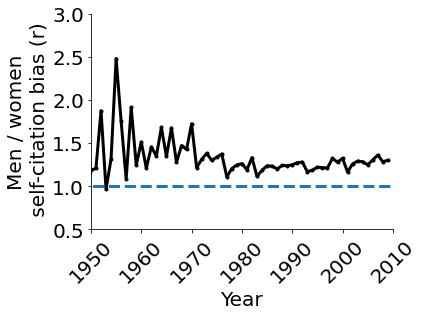

In [8]:
# calculate r-value
r1 = ((m_sc/selfcit)/(w_sc/selfcit))
r2 = ((wpop/pop)/(mpop/pop))
r = r1*r2

# create r-value plot
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

r.plot(style='.-', color='black', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950)
# plt.xlim(xmin=1960)
plt.xlim(xmax=2010)
plt.ylabel('Men / women\n self-citation bias (r)', fontsize=20)
# plt.ylim(ymin=0.5,ymax=3.5)
plt.ylim(ymin=0.5,ymax=3)
plt.hlines(1,xmin=1903,xmax=2010,linestyles='dashed', lw=3)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.tight_layout()

## Degree & PageRank Centrality Statistics

### Degree Centrality Proportion of Women Authors

In [9]:
# exclude alphabetically ordered papers
# only consider first authors
degcen = paperdata.query('is_alpha == False & order == 1')

# calculate degree centrality per paper
vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

# create a DataFrame with degree centrality
cited = pd.merge(cb_sub, degcen, left_index = True, right_on = 'doi').rename(
    columns = {'cited_doi': 'centrality'})
cited['yeard'] = 2010-cited['year']
cited.head()

,centrality,doi,id,gender,order,numAuthor,is_alpha,year,articleType,journal,...,pacs10,pacs20,pacs30,pacs40,pacs50,pacs60,pacs70,pacs80,pacs90,yeard
16644,5214,10.1103/PhysRev.140.A1133,219005,male,1,2,False,1965,article,PR,...,0,0,0,0,0,0,0,0,0,45
14878,4100,10.1103/PhysRev.136.B864,12626,male,1,2,False,1964,article,PR,...,0,0,0,0,0,0,0,0,0,46
151045,2519,10.1103/PhysRevB.13.5188,133666,male,1,2,False,1976,article,PRB,...,0,0,0,0,0,0,0,0,0,34
258027,2337,10.1103/PhysRevB.54.11169,157378,male,1,2,False,1996,article,PRB,...,0,0,0,0,0,0,1,0,0,14
3428,1679,10.1103/PhysRev.108.1175,165388,male,1,3,False,1957,article,PR,...,0,0,0,0,0,0,0,0,0,53


In [10]:
# Top k% degree centrality basic statistics

print(f"Top 10% Centrality ({cb_sub.cited_doi[len(cb_sub)//10]}+): ", 
      len(cited[cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10]]))
print(f"Men in Top 10% ({cb_sub.cited_doi[len(cb_sub)//10]}+): ",
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10]) & (cited['gender'] == "male")]))
print(f"Women in Top 10% ({cb_sub.cited_doi[len(cb_sub)//10]}+): ", 
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10]) & (cited['gender'] == "female")]))
print("")
print(f"Top 20% Centrality ({cb_sub.cited_doi[len(cb_sub)//10 * 2]}+): ", 
      len(cited[cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 2]]))
print(f"Men in Top 20% ({cb_sub.cited_doi[len(cb_sub)//10 * 2]}+): ",
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 2]) & (cited['gender'] == "male")]))
print(f"Women in Top 20% ({cb_sub.cited_doi[len(cb_sub)//10 * 2]}+): ", 
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 2]) & (cited['gender'] == "female")]))
print("")
print(f"Top 30% Centrality ({cb_sub.cited_doi[len(cb_sub)//10 * 3]}+): ", 
      len(cited[cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 3]]))
print(f"Men in Top 30% ({cb_sub.cited_doi[len(cb_sub)//10 * 3]}+): ",
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 3]) & (cited['gender'] == "male")]))
print(f"Women in Top 30% ({cb_sub.cited_doi[len(cb_sub)//10 * 3]}+): ", 
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 3]) & (cited['gender'] == "female")]))
print("")
print(f"Top 40% Centrality ({cb_sub.cited_doi[len(cb_sub)//10 * 4]}+): ", 
      len(cited[cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 4]]))
print(f"Men in Top 40% ({cb_sub.cited_doi[len(cb_sub)//10 * 4]}+): ",
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 4]) & (cited['gender'] == "male")]))
print(f"Women in Top 40% ({cb_sub.cited_doi[len(cb_sub)//10 * 4]}+): ", 
      len(cited[(cited['centrality'] >= cb_sub.cited_doi[len(cb_sub)//10 * 4]) & (cited['gender'] == "female")]))

Top 10% Centrality (25+):  24272
Men in Top 10% (25+):  22191
Women in Top 10% (25+):  2081

Top 20% Centrality (15+):  47843
Men in Top 20% (15+):  43534
Women in Top 20% (15+):  4309

Top 30% Centrality (10+):  73964
Men in Top 30% (10+):  67025
Women in Top 30% (10+):  6939

Top 40% Centrality (7+):  101289
Men in Top 40% (7+):  91376
Women in Top 40% (7+):  9913


In [11]:
def cummean(x):
    return x.cumsum() / (np.arange(1, len(x) + 1))

def plot_topk_mean_m(x):
    n = len(x)
    plt.plot(100 * (1 + np.arange(n)) / n, cummean(x[::-1]), color='#67a9cf',
             lw=3, label='men')

def plot_topk_mean_w(x):
    n = len(x)
    plt.plot(100 * (1 + np.arange(n)) / n, cummean(x[::-1]), color='#ef8a62',
             lw=3, label='women')

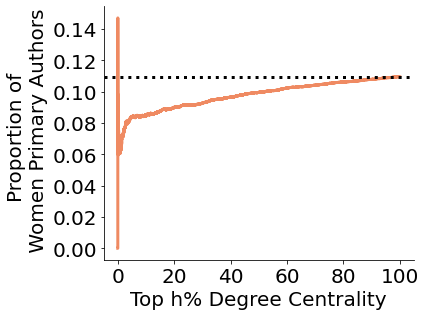

In [12]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plot_topk_mean_w(cited.sort_values(by='centrality')['gender'] == 'female')

plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited),
            color='black', linestyle='dotted', lw=3)

plt.xlabel("Top h% Degree Centrality", fontsize=20)
plt.ylabel("Proportion of \n Women Primary Authors", fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

(Trim the first year at will for better visualization and more accurate/appropriate results.)

### PageRank Centrality Proportion of Women Authors

In [13]:
cen1 = cb.copy()
cen2 = primdata[['doi','gender']]
# cen2 = lastdata[['doi','gender']]

cen = cen1.merge(cen2, left_on='citing_doi', right_on='doi').drop('doi', axis=1).reset_index(drop=True)
cen = cen.merge(cen2, left_on='cited_doi', right_on='doi').drop('doi', axis=1).reset_index(drop=True)
cen.columns = ['citing_doi', 'cited_doi', 'citing_gender', 'cited_gender']
cen.head()

,citing_doi,cited_doi,citing_gender,cited_gender
0,10.1103/PhysRevSeriesI.11.215,10.1103/PhysRevSeriesI.1.1,male,male
1,10.1103/PhysRevSeriesI.17.267,10.1103/PhysRevSeriesI.1.1,male,male
2,10.1103/RevModPhys.51.863,10.1103/PhysRevSeriesI.1.1,male,male
3,10.1103/PhysRevSeriesI.4.433,10.1103/PhysRevSeriesI.1.1,male,male
4,10.1103/PhysRevSeriesI.17.267,10.1103/PhysRevSeriesI.11.215,male,male


In [15]:
# apply nx.graph to citation relationship network
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi',
                            target='cited_doi', create_using=Graphtype)
# print(nx.info(C))

In [16]:
# observe author id & gender

#### IF PRIMARY
nodedata = primdata[['doi','id','gender']]

#### IF LAST
# nodedata = lastdata[['doi','id','gender']]

In [17]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['PRcen'] = pr.values()

# merge and create a dataframe: id, gender, PageRank centrality
prs_new = prs.merge(nodedata, on='doi', how='left').sort_values('PRcen', ascending=False)
prs_new.head()

,doi,PRcen,id,gender
5469,10.1103/PhysRev.140.A1133,0.001709,219005,male
42329,10.1103/PhysRev.136.B864,0.001404,12626,male
33589,10.1103/PhysRev.108.1175,0.001370,165388,male
48,10.1103/PhysRev.47.777,0.001022,38494,male
117022,10.1103/PhysRev.65.117,0.000763,59830,male


In [18]:
pr_age = prs_new.merge(cited, on='doi', how='inner')
pr_age = pr_age[['PRcen', 'doi', 'id_x', 'gender_x', 'yeard']]
pr_age = pr_age.rename(columns={'id_x': "id", "gender_x": "gender"}
                      ).sort_values('PRcen',ascending=False)

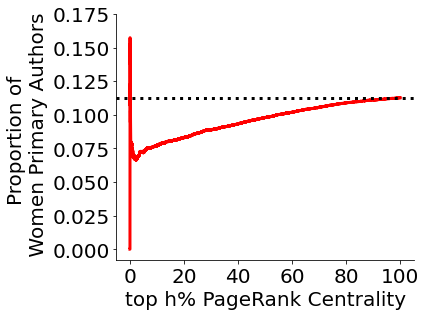

In [19]:
# Comparative graph for actual female proportion vs. expected female proportion

prs_gender = prs_new['gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot((np.arange(len(prs_new))*100)/len(prs_new),
         cumulate_prs_gender/np.arange(1, len(prs_new)+1), color='red', lw=3)
# plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted', lw=3)
plt.axhline(y=len(prs_new[prs_new['gender'] == 'female'])/len(prs_new),
            color='black', linestyle='dotted', lw=3)


plt.xlabel("top h% PageRank Centrality", fontsize=20)
plt.ylabel("Proportion of \n Women Primary Authors", fontsize = 20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymax=0.175)
plt.tight_layout()

(Trim the first year at will for better visualization and more accurate/appropriate results.)

### Degree & PageRank Centrality vs. Average Career Age (OR Average Paper Age)

In [21]:
# productivity table (from stat.ipynb)

prod = paperdata.copy().groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])

prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

year             career_age       prod
                min   max count                      
id     gender                                        
162998 male    1961  2009   491         48  10.229167
92641  male    1979  2009   443         30  14.766667
145071 male    1978  2009   442         31  14.258065
233941 male    1953  2009   400         56   7.142857
140103 male    1983  2009   396         26  15.230769

In [22]:
centca = cited.merge(prod, on='id', how='inner')
centca = centca[['centrality', 'doi', 'id', 'gender', 'order', 
                 ('career_age', '')]]
centca.rename(columns={('career_age', ''): "CA"}, inplace=True)
centca = centca.sort_values('centrality', ascending=False)

centca.head()

,centrality,doi,id,gender,order,CA
0,5214,10.1103/PhysRev.140.A1133,219005,male,1,62
50,2519,10.1103/PhysRevB.13.5188,133666,male,1,30
58,2337,10.1103/PhysRevB.54.11169,157378,male,1,16
71,1679,10.1103/PhysRev.108.1175,165388,male,1,60
121,1675,10.1103/PhysRev.124.1866,114066,male,1,50


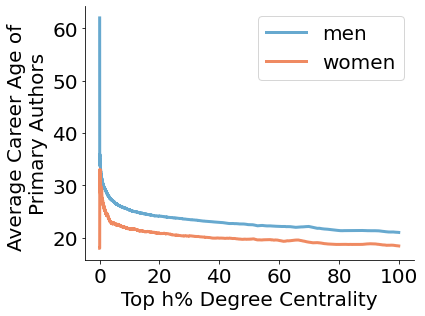

In [23]:
# Degree Centrality vs. Avg Author Career Age

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plot_topk_mean_m(centca[centca['gender'] == 'male'].sort_values(
    by='centrality')['CA'])

plot_topk_mean_w(centca[centca['gender'] == 'female'].sort_values(
    by='centrality')['CA'])

plt.xlabel("Top h% Degree Centrality", fontsize=20)
plt.ylabel("Average Career Age of \nPrimary Authors", fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.legend(loc='upper right', fontsize=20)

#### w/ in-set

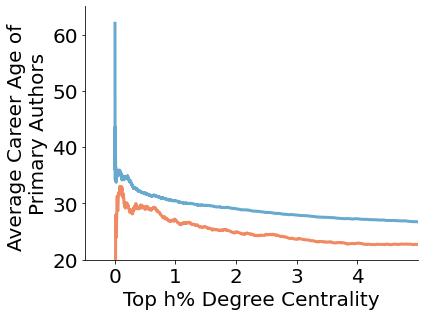

In [24]:
# Degree Centrality vs. Avg Author Career Age (w/ inset)

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

ccm = centca[centca['gender'] == 'male'].sort_values(by='centrality')
ccfm = centca[centca['gender'] == 'female'].sort_values(by='centrality')

plot_topk_mean_m(ccm.CA)
plot_topk_mean_w(ccfm.CA)

plt.xlabel("Top h% Degree Centrality", fontsize=20)
plt.ylabel("Average Career Age of \nPrimary Authors", fontsize=20)

plt.xlim(xmax=5,xmin=-0.5)
plt.ylim(ymax=65, ymin=20)
plt.xticks(np.arange(0, 5, 1), fontsize=20)
plt.yticks(np.arange(20, 65, 10), fontsize=20)
plt.tight_layout()